Original repository: https://github.com/clam004/intro_continual_learning

# Part 1 초기 모델

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'you are using {device}, PyTorch version: {torch.__version__}')

you are using cuda, PyTorch version: 1.10.0+cu111


In [3]:
from pathlib import Path

# 1. 데이터셋 불러오기
dir = Path('비공개')
img_paths = list(dir.glob('비공개')) + list(dir.glob('비공개'))
labels = [0]*1000 + [1]*1000

print('개수 확인:', len(img_paths), len(labels))

개수 확인: 2000 2000


In [4]:
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(img_paths, labels, stratify=labels,
                                                      random_state=42, test_size=0.2, shuffle=True, )

In [5]:
print(len(X_train), len(X_test))

1600 400


In [7]:
# Dataset: 데이터 어떻게 불러올건지 정의
from torchvision.transforms import transforms
from torch.utils.data import Dataset
from PIL import Image

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224, 224)), ])

class EgdDataset(Dataset):
     def __init__(self, img_paths, labels, transform):
          # self.img_paths = img_paths
          # self.labels = labels 
          self.imgs = [transform(Image.open(img)) for img in img_paths]
          self.labels = torch.Tensor([label for label in labels])
          self.transform = transform
     
     def __len__(self):
          return len(self.labels)
     
     def __getitem__(self, idx):
          # img_path = self.img_paths[idx]
          # img = self.transform(Image.open(img_path).convert("RGB"))
          # label = torch.tensor(self.labels[idx])
          img = self.imgs[idx]
          label = self.labels[idx]
          return img, label

train_dataset = EgdDataset(X_train, y_train, transform)
test_dataset = EgdDataset(X_test, y_test, transform)

print(f"train set: {len(train_dataset)}, test set: {len(test_dataset)}")

train set: 1600, test set: 400


참고:  
- train_dataset: len=1600 이미지 갯수
- train_dataset[0]: len=2 (img, label)
- train_dataset[0][0]: [3, 224, 224] 

In [ ]:
# 변형된 이미지 출력
import matplotlib.pyplot as plt
tmp = train_dataset[0][0].permute(1, 2, 0).numpy() # imshow로 뿌려주기 위해 (w, h, 채널) 으로 변환 후 
plt.imshow(tmp); plt.show()

In [9]:
# 2. 데이터 적재 (DataLoader)
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True, num_workers=0) # num_worker 수정하면 에러남
test_loader  = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False, num_workers=0)

참고  
- len( iter(train_loader) ): mini_batch 갯수(=전체 갯수 / batch_size)
- len( next(iter(train_loader)) ): 2 (=imgs, labels)
- len( next(iter(train_loader))[0] ): 8 (=batch_size)
- next(iter(train_loader))[0][0]: 첫번째 배치의 첫번째 이미지 크기 [3, 224, 224] 

In [ ]:
tmp = next(iter(train_loader))[0][0]    # 첫 번째 mini-batch의 첫 번째 요소
print(tmp.size())

plt.imshow(tmp.permute(1, 2, 0).numpy()); plt.show()

### 모델 구성

In [11]:
# autorelod: 모듈 수정 후 자동으로 reload. 
#            .py 수정 후 다시 import 안 해도 됨
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
import numpy as np
from tqdm.notebook import tqdm
from contlearn.gettrainer import one_epoch_baseline, test, var2device

def baseline_training(
    model, 
    epochs,
    train_loader,
    test_loader,
    test2_loader = None,
):  
    """
    This function saves the training curve data consisting
    training set loss and validation set accuracy over the
    course of the epochs of training.
    
    I set this up such that if you provide 2 test sets, 
    you can watch the test accuracy change together during training
    on train_loder
    """
    
    train_loss, train_acc, test_acc, test2_acc = [], [], [], []
    best_acc = 0.0
    
    for epoch in tqdm(range(epochs)):
        
        # 훈련
        epoch_loss = one_epoch_baseline(model, train_loader)
        train_loss.append(epoch_loss)
        
        # 정확도 저장
        acc = test(model, train_loader)
        train_acc.append(acc.detach().cpu().numpy())
        
        acc = test(model, test_loader)
        test_acc.append(acc.detach().cpu().numpy())
        
        if test2_loader is not None:
            acc = test(model, test2_loader)
            test2_acc.append(acc.detach().cpu().numpy())
            
        if test_acc[-1] > best_acc:
            best_acc = test_acc[-1]
            torch.save(model, "results/baseline_best2.pth")
        
    # save the trained model
    torch.save(model, "results/baseline_last2.pth")
    
    return train_loss, train_acc, test_acc, test2_acc, model

- 참고: 모델 저장시 model vs model.state_dict()
     - torch.save(model): 모델 전체 저장 (파라미터, 옵티마이저, 에포크 등). 타인한테 그대로 주면 쓸 수 있을 정도로 편리하나 용량도 크다
     - torch.save(model.state_dict()): 파라미터(가중치, 편향)만 저장. 모델이 구현되어있는 경우 파라미터를 채워서 사용할 수 있음. 전이학습에 유용

**훈련**

In [ ]:
# 모델 정의: models > vgg
# 모델 초기화
from models.vgg import bn_vgg11b
model = bn_vgg11b(num_classes=4, in_size=(224, 224))

if str(device) == "cuda":
    model.cuda()

# 3. 훈련 (단순 분류 모델 사용)
train_loss, train_acc, test_acc, test2_acc, model = baseline_training(
    model,
    epochs = 10,
    train_loader = train_loader,
    test_loader = test_loader,
)

**성능 확인**

In [15]:
# metrics 따로 복사해두기
from copy import deepcopy
baseline_train_loss = deepcopy(train_loss)
baseline_train_acc = deepcopy(train_acc)
baseline_test_acc = deepcopy(test_acc)
baseline_model = deepcopy(model)

In [17]:
acc = test(baseline_model.cuda(), train_loader)
print("accuracy on train set", acc.item())
acc = test(baseline_model.cuda(), test_loader)
print("accuracy on test set", acc.item())

accuracy on train set 0.9312499761581421
accuracy on test set 0.9199999570846558


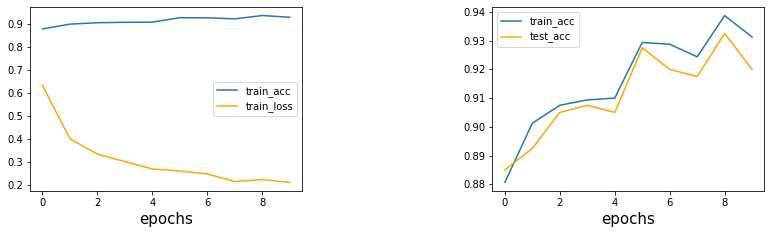

In [18]:
# 4. 성능 확인(그래프): train_loss, test_acc
'''plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('test accuracy', fontsize=25)
plt.plot(test_acc); plt.show()'''

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

ax = axes[0]
ax.plot(train_acc)
ax.set_xlabel('epochs', fontsize=15)
ax.plot(train_loss, c='orange')
ax.legend(['train_acc', 'train_loss'])

ax = axes[1]
ax.plot(train_acc)
ax.set_xlabel('epochs', fontsize=15)
ax.plot(test_acc, c='orange')
ax.legend(['train_acc', 'test_acc'])

# subplot 간 간격 조절
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95, wspace=0.7, hspace=0.5)
plt.show()

epoch=50일때 trainset에 과적합 되는 모습 보여서 epoch=10으로 훈련한 모델을 사용

# Part 2. Catastrophic Forgetting  
- pretrained 불러와서 이어서 학습

In [ ]:
# 새로운 데이터 불러오기
from pathlib import Path
img_paths_2 = list(Path(r'비공개').glob('*'))
labels_2 = [2]*1000 + [3]*1000

print('개수 확인:', len(img_paths), len(labels))

개수 확인: 2000 2000


In [80]:
# 데이터 적재
from sklearn.model_selection import train_test_split
(X_train_2, X_test_2, y_train_2, y_test_2) = train_test_split(img_paths_2, labels_2,
                                                      random_state=42, test_size=0.1, shuffle=True, stratify=labels_2)

train_dataset_2 = EgdDataset(X_train_2, y_train_2, transform)
test_dataset_2 = EgdDataset(X_test_2, y_test_2, transform)

train_loader_2 = DataLoader(dataset=train_dataset_2, batch_size=8, shuffle=True, num_workers=0)
test_loader_2 = DataLoader(dataset=test_dataset_2, batch_size=8, shuffle=False, num_workers=0)

In [ ]:
from models.vgg import bn_vgg11b
# model = bn_vgg11b(num_classes=4, in_size=(224, 224))
model = torch.load("results/baseline_last2.pth")

train_loss, train_acc, test_acc, test2_acc, model = baseline_training(
    model.cuda(),
    epochs = 2,
    train_loader = train_loader_2,
    test_loader = test_loader_2,    # new task (class: adenoma)
    test2_loader = test_loader,     # old task (class: normal, cancer)
)

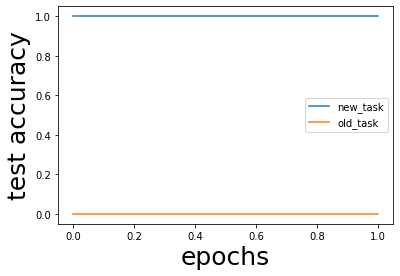

In [87]:
# 성능 확인 (그래프)
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('test accuracy', fontsize=25)
plt.plot(test_acc)
plt.plot(test2_acc)
plt.legend(['new_task', 'old_task'])
plt.show()

과거 task는 정확도가 0.5 정도로 떨어짐

- 전체 데이터셋으로도 테스트

In [ ]:
# 전체 데이터 불러오기
dir = Path(r'비공개')
img_paths2 = list(dir.glob('*/*'))
labels2 = [0]*1000 + [1]*1000 + [2]*1000 + [3]*1000

# 데이터 적재

from sklearn.model_selection import train_test_split
(X_train2, X_test2, y_train2, y_test2) = train_test_split(img_paths2, labels2,
                                                      random_state=42, test_size=0.1, shuffle=True, stratify=labels2)
(X_train2, X_val2, y_train2, y_val2) = train_test_split(X_train2, y_train2,
                                                      random_state=42, test_size=0.2, stratify=y_train2)

train_dataset2 = EgdDataset(X_train2, y_train2, transform)
test_dataset2 = EgdDataset(X_test2, y_test2, transform)

train_loader2 = DataLoader(dataset=train_dataset2, batch_size=2, shuffle=True, num_workers=0)
test_loader2 = DataLoader(dataset=test_dataset2, batch_size=2, shuffle=False, num_workers=0)

In [21]:
acc = test(model, test_loader)
acc = acc.detach().cpu().numpy()
print('새로운 class 추가 후 과거 데이터에서의 정확도: ', acc)

total_acc = test(model, test_loader2)
total_acc = total_acc.detach().cpu().numpy()
print('새로운 class 추가 후 전체 데이터에서의 정확도:', total_acc)

새로운 class 추가 후 과거 데이터에서의 정확도:  0.505
새로운 class 추가 후 전체 데이터에서의 정확도 0.67


# Part 2 EWC
- Class: normal, cancer **+ adenoma**

1. old task로부터 샘플 추출 (mini-batch size만큼)

In [ ]:
# instead of revisiting every old MNIST example to build our Fisher Information Matrix
# use num_samples of them to calculate a approximate of the matrix
import random
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

num_batches = 200 # 수정: 우선 임의의 수로 지정함

old_tasks = []

for sample in range(num_batches):
    input_batch, target_batch = next(iter(train_loader))
    for image in input_batch:
        old_tasks.append(image)

In [115]:
np.array(old_tasks[0]).shape
#len(old_tasks)

(3, 224, 224)

old_task에서의 정확도 확인

In [175]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 모델 새로 정의: models > vgg
from models.vgg import bn_vgg11b
model = bn_vgg11b(num_classes=4, in_size=(224, 224))

### load a model previously trained on one task, task A ###
model = torch.load("results/basemodel2.pth")

model.cuda()    
# tensor(0.8238, device='cuda:0') means that the test set accuracy was 82.4%
# compared to a baseline accuracy of 10% if the model is choosing randomly
acc = test(model, test_loader)
print("accuracy on test set", acc.item())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
accuracy on test set 0.9649999737739563


In [176]:
# EWC: gettrainer.py에 정의해놓음
from contlearn.gettrainer import EWC
# old task에 사전학습된 모델을 EWC 클래스로 감싸주기
# place the model pretrained on mnist, but not fashion-mnist, along with some mnist examples
# into the Elastic Weight Consolidation object to perform EWC related tasks like calculating the Fisher Matrix
ewc = EWC(model, old_tasks)

In [118]:
# 파라미터 초기화
from copy import deepcopy

precision_matrices = {}
for n, p in deepcopy(ewc.params).items():
    
    print("name of this layer's weights:", n)
    p.data.zero_()
    precision_matrices[n] = var2device(p.data)
    print("shape of this matrix W:", precision_matrices[n].shape)
    #print(precision_matrices[n])
    print("norm of the matrix", torch.norm(precision_matrices[n]).item())
    break

name of this layer's weights: features.stage1.unit1.conv.weight
shape of this matrix W: torch.Size([32, 3, 3, 3])
norm of the matrix 0.0


ewc 모델 학습 전 성능 확인

In [121]:
(input[0]).shape

torch.Size([3, 224, 224])

In [ ]:
from torch.nn import functional as F

ewc.model.eval()
for input in ewc.dataset:
    ewc.model.zero_grad()
    
    input = input.view(1, input.size(0), input.size(1), input.size(2))
    input = var2device(input)
    output = ewc.model(input).view(1, -1)
    label = output.max(1)[1].view(-1)
    loss = F.nll_loss(F.log_softmax(output, dim=1), label)
    loss.backward()    
    break

print("input.shape", input.shape)
#img = Image.fromarray(input[0].detach().cpu().numpy())*255)
tmp = input[0].detach().cpu().permute(1, 2, 0).numpy()
plt.imshow(tmp)

print(list(output.detach().cpu().numpy()[0]))
print("predicted number", label)
print("loss", loss.item())

In [154]:
from contlearn.gettrainer import one_epoch_ewc

def ewc_training(
    ewc,
    importance,
    model, 
    epochs, 
    train_loader,
    val_loader,
    test_loader = None,
    use_cuda=True, 
):
    
    """
    This function saves the training curve data consisting
    training set loss and validation set accuracy over the
    course of the epochs of training.
    
    I set this up such that if you provide 2 test sets,you
    can watch the test accuracy change together during training
    on train_loder
    """
    
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
        
    train_loss, val_acc, test_acc = [], [], []
    
    for epoch in tqdm(range(epochs)):

        epoch_loss = one_epoch_ewc(ewc,importance, model, train_loader)
        train_loss.append(epoch_loss)
        
        acc = test(model,val_loader)
        val_acc.append(acc.detach().cpu().numpy())
        
        if test_loader is not None:
            acc2 = test(model,test_loader)
            test_acc.append(acc2.detach().cpu().numpy())
            
    return train_loss, val_acc, test_acc, model 

In [ ]:
import random
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc, model = ewc_training(
    ewc = ewc,
    importance = 900,
    model = model,
    epochs = 30,
    train_loader = train_loader_new,
    val_loader = test_loader,
    test_loader = test_loader2,
)

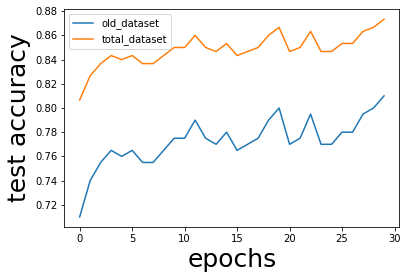

In [180]:
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('test accuracy', fontsize=25)
plt.plot(val_acc, label='old_dataset')
plt.plot(val2_acc, label='total_dataset')
plt.legend()
plt.show()

importance=900

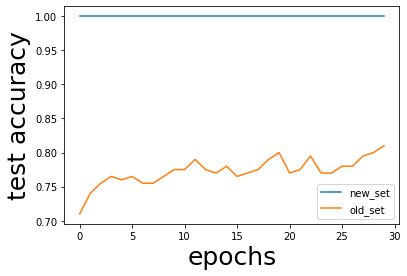

새로운 class 추가 후 과거 데이터에서의 정확도:  0.81
새로운 class 추가 후 전체 데이터에서의 정확도: 0.87333333


In [172]:
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('test accuracy', fontsize=25)
plt.plot(val_acc, label='new_set')
plt.plot(val2_acc, label='old_set')
plt.legend()
plt.show()

acc = test(model.to(device), test_loader)
acc = acc.detach().cpu().numpy()
print('새로운 class 추가 후 과거 데이터에서의 정확도: ', acc)

total_acc = test(model.to(device), test_loader2)
total_acc = total_acc.detach().cpu().numpy()
print('새로운 class 추가 후 전체 데이터에서의 정확도:', total_acc)

# 모델 저장
#torch.save(ewc.model.cpu(), "results/ewcmodel_2.pth")

- importance=800

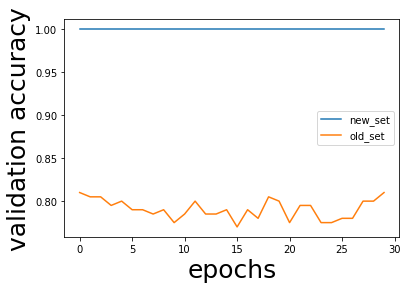

새로운 class 추가 후 과거 데이터에서의 정확도:  0.81
새로운 class 추가 후 전체 데이터에서의 정확도: 0.87333333


In [164]:
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('validation accuracy', fontsize=25)
plt.plot(val_acc, label='new_set')
plt.plot(val2_acc, label='old_set')
plt.legend()
plt.show()

acc = test(model.to(device), test_loader)
acc = acc.detach().cpu().numpy()
print('새로운 class 추가 후 과거 데이터에서의 정확도: ', acc)

total_acc = test(model.to(device), test_loader2)
total_acc = total_acc.detach().cpu().numpy()
print('새로운 class 추가 후 전체 데이터에서의 정확도:', total_acc)

# 모델 저장
torch.save(ewc.model.cpu(), "results/ewcmodel_2.pth")

- importance 700일때

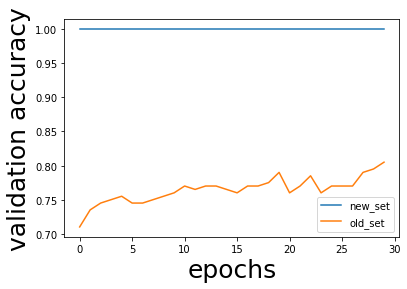

새로운 class 추가 후 과거 데이터에서의 정확도:  0.805
새로운 class 추가 후 전체 데이터에서의 정확도: 0.87


In [162]:
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('validation accuracy', fontsize=25)
plt.plot(val_acc, label='new_set')
plt.plot(val2_acc, label='old_set')
plt.legend()
plt.show()

acc = test(model.to(device), test_loader)
acc = acc.detach().cpu().numpy()
print('새로운 class 추가 후 과거 데이터에서의 정확도: ', acc)

total_acc = test(model.to(device), test_loader2)
total_acc = total_acc.detach().cpu().numpy()
print('새로운 class 추가 후 전체 데이터에서의 정확도:', total_acc)

# 모델 저장
torch.save(ewc.model.cpu(), "results/ewcmodel_2.pth")

**아래는 ewc 람다값 바꿔가며 실험해본것... 무시할 것**

importance=1000일때

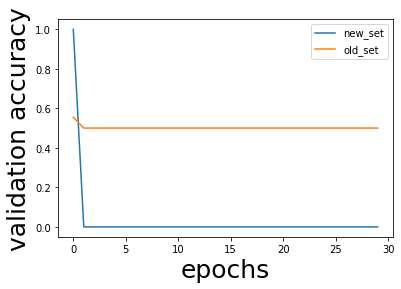

새로운 class 추가 후 과거 데이터에서의 정확도:  0.5
새로운 class 추가 후 전체 데이터에서의 정확도: 0.33333334


In [157]:
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('validation accuracy', fontsize=25)
plt.plot(val_acc, label='new_set')
plt.plot(val2_acc, label='old_set')
plt.legend()
plt.show()

acc = test(model.to(device), test_loader)
acc = acc.detach().cpu().numpy()
print('새로운 class 추가 후 과거 데이터에서의 정확도: ', acc)

total_acc = test(model.to(device), test_loader2)
total_acc = total_acc.detach().cpu().numpy()
print('새로운 class 추가 후 전체 데이터에서의 정확도:', total_acc)

importance=500일 때

In [151]:
acc = test(model.to(device), test_loader)
acc = acc.detach().cpu().numpy()
print('새로운 class 추가 후 과거 데이터에서의 정확도: ', acc)

total_acc = test(model.to(device), test_loader2)
total_acc = total_acc.detach().cpu().numpy()
print('새로운 class 추가 후 전체 데이터에서의 정확도:', total_acc)

새로운 class 추가 후 과거 데이터에서의 정확도:  0.79999995
새로운 class 추가 후 전체 데이터에서의 정확도: 0.8666667


importance=200일 때

In [149]:
acc = test(model.to(device), test_loader)
acc = acc.detach().cpu().numpy()
print('새로운 class 추가 후 과거 데이터에서의 정확도: ', acc)

total_acc = test(model.to(device), test_loader2)
total_acc = total_acc.detach().cpu().numpy()
print('새로운 class 추가 후 전체 데이터에서의 정확도:', total_acc)

새로운 class 추가 후 과거 데이터에서의 정확도:  0.755
새로운 class 추가 후 전체 데이터에서의 정확도: 0.8366667


importance=100일때

In [147]:
model = torch.load("results/ewcmodel1.pth")

acc = test(model.to(device), test_loader)
acc = acc.detach().cpu().numpy()
print('새로운 class 추가 후 과거 데이터에서의 정확도: ', acc)

total_acc = test(model.to(device), test_loader2)
total_acc = total_acc.detach().cpu().numpy()
print('새로운 class 추가 후 전체 데이터에서의 정확도:', total_acc)

새로운 class 추가 후 과거 데이터에서의 정확도:  0.71999997
새로운 class 추가 후 전체 데이터에서의 정확도: 0.81333333


In [135]:
tmp = ewc.model.cpu()
torch.save(tmp, "results/ewcmodel1.pth")

importance=50일 때

In [145]:
ewc.model.eval()

acc = test(ewc.model.to(device), test_loader)
acc = acc.detach().cpu().numpy()
print('새로운 class 추가 후 과거 데이터에서의 정확도: ', acc)

total_acc = test(ewc.model.to(device), test_loader2)
total_acc = total_acc.detach().cpu().numpy()
print('새로운 class 추가 후 전체 데이터에서의 정확도:', total_acc)

새로운 class 추가 후 과거 데이터에서의 정확도:  0.695
새로운 class 추가 후 전체 데이터에서의 정확도: 0.7966667
